## Practica gradient descent y tensorboard
### Alvaro Andres Esquivel Gomez - 11002822

In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime

print(tf.__version__)

2.1.0


In [2]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


In [3]:
#Importando los datos
data = np.load("proyecto_training_data.npy")

print("Rango del tensor:",data.ndim) 
print("Forma o tamaño:",data.shape) 
print(data)
len_data = len(data)
print("\nCantidad de datos:",len_data)

Rango del tensor: 2
Forma o tamaño: (1460, 6)
[[2.08500e+05 7.00000e+00 8.56000e+02 8.00000e+00 2.00300e+03 6.50000e+01]
 [1.81500e+05 6.00000e+00 1.26200e+03 6.00000e+00 1.97600e+03 8.00000e+01]
 [2.23500e+05 7.00000e+00 9.20000e+02 6.00000e+00 2.00100e+03 6.80000e+01]
 ...
 [2.66500e+05 7.00000e+00 1.18800e+03 9.00000e+00 1.94100e+03 6.60000e+01]
 [1.42125e+05 5.00000e+00 1.07800e+03 5.00000e+00 1.95000e+03 6.80000e+01]
 [1.47500e+05 5.00000e+00 1.25600e+03 6.00000e+00 1.96500e+03 7.50000e+01]]

Cantidad de datos: 1460


Correlacion entre calidad de materiales y precio
Coeficiente:  0.7939900504626405


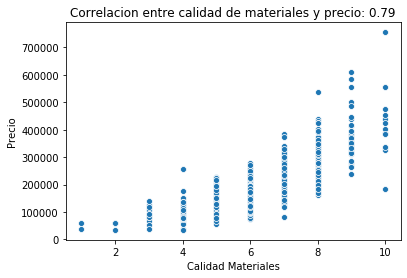

In [4]:
datos_entrenamiento = data[0:int(len_data*0.8)]
datos_validacion = data[int(len_data*0.8):len_data]

#Variables de dataset entrenamiento
precio = datos_entrenamiento[:,0]
calidad_materiales = datos_entrenamiento[:,1]

coefcorr_calidad_materiales = np.corrcoef(calidad_materiales, precio)[1,0]
print("Correlacion entre calidad de materiales y precio")
print("Coeficiente: ", coefcorr_calidad_materiales)
titulo = "Correlacion entre calidad de materiales y precio: " + str("%.2f" % round(coefcorr_calidad_materiales, 2))
dataset = pd.DataFrame({'Calidad Materiales': calidad_materiales, 'Precio': precio})
ax = sns.scatterplot(x="Calidad Materiales", y="Precio", data=dataset).set_title(titulo)


In [5]:
#Funcion de error o de costo del modelo

def error(y_real,y_aprox):
    return 1/2*tf.reduce_mean(tf.math.square(y_real - y_aprox) )

In [44]:
tam_muestra = len(datos_entrenamiento)

x = calidad_materiales
y = precio


observaciones = np.ones((len(x),2))
#print(observaciones)
observaciones[:,0] = x

### Funcion para modelo de regresion lineal vectorizado

In [26]:

def mod_regresion_lineal(x, y, lr, epochs, n_visualizaciones):
    #Visualizacion del entrenamiento
    plt.scatter(x,y)

    #Reinicio del grafo
    tf.reset_default_graph()

    with tf.name_scope("Hiperparametros"):
        #Hiperparametros
        learning_rate = lr
        training_epochs = epochs

    with tf.name_scope("Parametros_entrenables"):
        #Parametros entrenables del modelo iniciando en 0,0
        par_entrenables = tf.get_variable("parametros_entrenables",dtype=tf.float32, shape=[2],
                      initializer=tf.zeros_initializer())
        l_rate = tf.get_variable("l_rate",dtype=tf.float32, shape=[],
                      initializer=tf.zeros_initializer())

    with tf.name_scope("Placeholders"):
        #Datos para el modelo, tam_muesta = total de elementos que tiene el modelo 
        tensor_x = tf.placeholder(tf.float32,[len(x)],"tensor_x")
        tensor_y = tf.placeholder(tf.float32,[len(y)],"tensor_y")
        observaciones = tf.placeholder(tf.float32,[len(x), 2],"observaciones")

    with tf.name_scope("Prediccion_y-hat"):
        #Hipotesis del modelo con la ecuacion: y = mx + b
        #Predice todos los resultados de y
        prediccion = tf.linalg.matvec(observaciones, par_entrenables, name = "Calculo_prediccion")
    
    with tf.name_scope("Gradientes"):
        #Gradiente de funcion de error para m y b estimado, con y_reales y y_predecidos
        #grad = tf.gradients(error(tensor_y,prediccion) ,par_entrenables )
        gradiente = tf.gradients(error(tensor_y,prediccion),par_entrenables, name = "Calculo_gradientes")
    
    val_error = error(tensor_y,prediccion)
    
    with tf.name_scope("Val_escalares_entrenamiento"):
        #Escalares para tensorboard
        m = tf.summary.scalar(name='m', tensor=par_entrenables[0])
        b = tf.summary.scalar(name='b', tensor=par_entrenables[1])
        es_error = tf.summary.scalar(name='es_error', tensor=val_error)

    with tf.name_scope("Parametros_m_b"):
        #Acualiza los valores de la pendiente e intercepto segun Gradient Descent
        actualizacion_parametros = tf.assign(par_entrenables, tf.squeeze(par_entrenables - (l_rate * gradiente)),
                                         name = "Actualizacion_parametros")


    #Utilizando el algoritmo de batch gradient descent
    #Crea una sesion
    with tf.train.MonitoredSession() as session:
        #Agrega las observaciones a un vextor con valores: x - 1
        np_observaciones = np.ones((len(x),2))
        #Agrega valores de x
        np_observaciones[:,0] = x
        
        #Diccionario de entrada con valores de X y Y del modelo
        #Envia todo el set de datos al modelo
        feed_dict = {tensor_x:x, tensor_y:y, observaciones:np_observaciones, l_rate:learning_rate}
        
        #Logs con TensorBoard
        now = datetime.now()
        fecha_hora = now.strftime("%Y%m%d-%H%M%S")
        #String de configuración para cada experimento
        path = "./logs/"+fecha_hora + "_lr=" + str(lr) + "_epochs=" +  str(epochs)
        print("String experimento:", path)
        
        #Imprime grafo en TensorBoard
        writer = tf.summary.FileWriter(path, session.graph)

        #Interacion por cada epoch, segun fue definido
        for i in range(training_epochs):

            #Imprime los valores del error cada cierta cantidad de interaciones
            if (i) % n_visualizaciones == 0: 
                #Derivada parcial del error respecto a m y b
                session.run(gradiente,feed_dict=feed_dict)
                s = session.run(par_entrenables,feed_dict=feed_dict)
                print("Ejecucion:", i, "Gradiente del error respecto de m y b:", s, 
                      "error: ", session.run(val_error,feed_dict=feed_dict))
                
                #Agrega los valores a TensorBoard
                summary = session.run(m)
                writer.add_summary(summary, i)
                summary = session.run(b)
                writer.add_summary(summary, i)
                summary = session.run(es_error,feed_dict=feed_dict)
                writer.add_summary(summary, i)
            else:
                session.run(gradiente,feed_dict=feed_dict)

            #Actualiza a los nuevos parametros
            session.run(actualizacion_parametros,feed_dict=feed_dict)

            #Predicciones segun los nuevos parametros
            predicciones = session.run(prediccion,feed_dict=feed_dict)

            #Graficando los valores de X segun las nuevas predicciones de Y
            plt.plot(x,predicciones,label=str(i))

    writer.close()
    plt.show()
  

### Grafico del grafo

![title](img/grafo.png)


### Pruebas de entrenamiento

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
String experimento: ./logs/20200601-193256_lr=0.01_epochs=1000
Ejecucion: 0 Gradiente del error respecto de m y b: [0. 0.] error:  19409727000.0
Ejecucion: 50 Gradiente del error respecto de m y b: [29995.701   2260.2834] error:  1383303800.0
Ejecucion: 100 Gradiente del error respecto de m y b: [30356.46       -50.108013] error:  1372369800.0
Ejecucion: 150 Gradiente del error respecto de m y b: [30708.775  -2306.4312] error:  1361942000.0
Ejecucion: 200 Gradiente del error respecto de m y b: [31052.848  -4509.9546] error:  1351995900.0
Ejecucion: 250 Gradiente del error respecto de m y b: [31388.87  -6661.915] error:  1342509400.0
Ejecucion: 300 Gradiente del error respecto de m y b: [31717.025 -8763.518] error:  1333462500.0
Ejecucion: 350 Gradiente del error respecto de m y b: [ 32037.504 -10815.935] error:  1324833500.0
Ejecucion: 400 Gradiente del error respecto

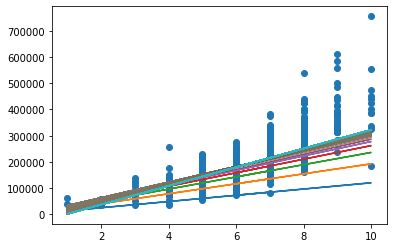

In [27]:
mod_regresion_lineal(x, y, 0.01, 1000, 50)

![title](img/20200601-193256.png)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
String experimento: ./logs/20200601-193904_lr=0.1_epochs=1000
Ejecucion: 0 Gradiente del error respecto de m y b: [0. 0.] error:  19409727000.0
Ejecucion: 50 Gradiente del error respecto de m y b: [-2.399741e+28 -3.747107e+27] error:  inf
Ejecucion: 100 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 150 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 200 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 250 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 300 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 350 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 400 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 450 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 500 Gradiente del erro

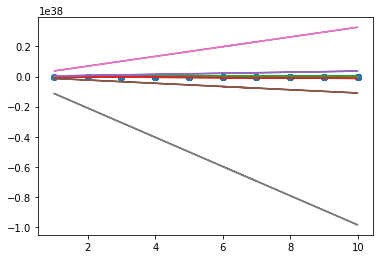

In [28]:
mod_regresion_lineal(x, y, 0.1, 1000, 50)

![title](img/20200601-193904.png)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
String experimento: ./logs/20200601-193933_lr=1_epochs=1000
Ejecucion: 0 Gradiente del error respecto de m y b: [0. 0.] error:  19409727000.0
Ejecucion: 50 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 100 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 150 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 200 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 250 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 300 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 350 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 400 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 450 Gradiente del error respecto de m y b: [nan nan] error:  nan
Ejecucion: 500 Gradiente del error respecto de m y b: [

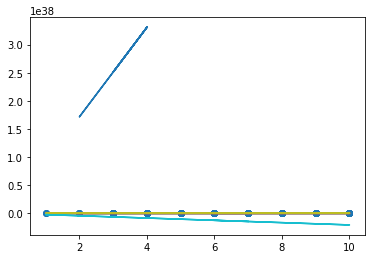

In [29]:
mod_regresion_lineal(x, y, 1, 1000, 50)

![title](img/20200601-1939331.png)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
String experimento: ./logs/20200601-193947_lr=0.001_epochs=1000
Ejecucion: 0 Gradiente del error respecto de m y b: [0. 0.] error:  19409727000.0
Ejecucion: 50 Gradiente del error respecto de m y b: [25830.098   3788.3918] error:  1695228000.0
Ejecucion: 100 Gradiente del error respecto de m y b: [29204.822   4071.0403] error:  1397482500.0
Ejecucion: 150 Gradiente del error respecto de m y b: [29673.828   3900.5493] error:  1391356800.0
Ejecucion: 200 Gradiente del error respecto de m y b: [29766.773  3671.914] error:  1390119400.0
Ejecucion: 250 Gradiente del error respecto de m y b: [29810.977   3436.2434] error:  1388969200.0
Ejecucion: 300 Gradiente del error respecto de m y b: [29848.8   3200.15] error:  1387826000.0
Ejecucion: 350 Gradiente del error respecto de m y b: [29885.72    2964.4873] error:  1386687900.0
Ejecucion: 400 Gradiente del error respecto de m

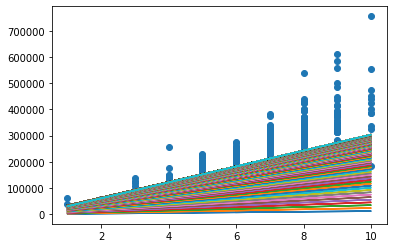

In [30]:
mod_regresion_lineal(x, y, 0.001, 1000, 50)

![title](img/20200601-193947.png)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
String experimento: ./logs/20200601-194047_lr=0.0001_epochs=1000
Ejecucion: 0 Gradiente del error respecto de m y b: [0. 0.] error:  19409727000.0
Ejecucion: 50 Gradiente del error respecto de m y b: [5392.624    817.52435] error:  13451974000.0
Ejecucion: 100 Gradiente del error respecto de m y b: [9805.034  1481.9973] error:  9464440000.0
Ejecucion: 150 Gradiente del error respecto de m y b: [13415.524   2021.2598] error:  6795566000.0
Ejecucion: 200 Gradiente del error respecto de m y b: [16369.962   2458.0872] error:  5009262000.0
Ejecucion: 250 Gradiente del error respecto de m y b: [18787.678  2811.114] error:  3813659600.0
Ejecucion: 300 Gradiente del error respecto de m y b: [20766.303  3095.584] error:  3013409000.0
Ejecucion: 350 Gradiente del error respecto de m y b: [22385.701   3323.9688] error:  2477767200.0
Ejecucion: 400 Gradiente del error respecto de

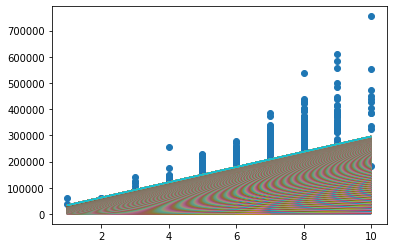

In [31]:
mod_regresion_lineal(x, y, 0.0001, 1000, 50)

![title](img/20200601-194047.png)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
String experimento: ./logs/20200601-194147_lr=0.0001_epochs=2000
Ejecucion: 0 Gradiente del error respecto de m y b: [0. 0.] error:  19409727000.0
Ejecucion: 100 Gradiente del error respecto de m y b: [9805.034  1481.9973] error:  9464440000.0
Ejecucion: 200 Gradiente del error respecto de m y b: [16369.962   2458.0872] error:  5009262000.0
Ejecucion: 300 Gradiente del error respecto de m y b: [20766.303  3095.584] error:  3013409000.0
Ejecucion: 400 Gradiente del error respecto de m y b: [23711.215   3506.4702] error:  2119226400.0
Ejecucion: 500 Gradiente del error respecto de m y b: [25684.697  3765.692] error:  1718542700.0
Ejecucion: 600 Gradiente del error respecto de m y b: [27008.006   3923.4153] error:  1538924700.0
Ejecucion: 700 Gradiente del error respecto de m y b: [27896.148  4013.213] error:  1458335100.0
Ejecucion: 800 Gradiente del error respecto de m

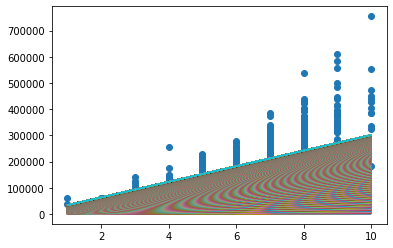

In [33]:
mod_regresion_lineal(x, y, 0.0001, 2000, 100)

![title](img/20200601-194147.png)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
String experimento: ./logs/20200601-194210_lr=0.01_epochs=100
Ejecucion: 0 Gradiente del error respecto de m y b: [0. 0.] error:  19409727000.0
Ejecucion: 10 Gradiente del error respecto de m y b: [29523.895  4120.758] error:  1393074400.0
Ejecucion: 20 Gradiente del error respecto de m y b: [29774.05   3672.842] error:  1390117200.0
Ejecucion: 30 Gradiente del error respecto de m y b: [29848.982   3199.8667] error:  1387824600.0
Ejecucion: 40 Gradiente del error respecto de m y b: [29922.518  2728.963] error:  1385553300.0
Ejecucion: 50 Gradiente del error respecto de m y b: [29995.701   2260.2834] error:  1383303800.0
Ejecucion: 60 Gradiente del error respecto de m y b: [30068.537   1793.8181] error:  1381075600.0
Ejecucion: 70 Gradiente del error respecto de m y b: [30141.03    1329.5565] error:  1378867800.0
Ejecucion: 80 Gradiente del error respecto de m y b: [30

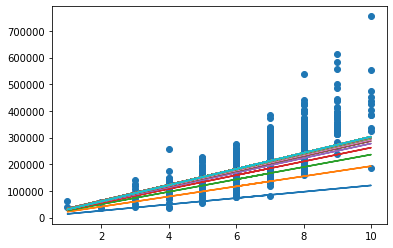

In [34]:
mod_regresion_lineal(x, y, 0.01, 100, 10)

![title](img/20200601-194210.png)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
String experimento: ./logs/20200601-194227_lr=0.01_epochs=50
Ejecucion: 0 Gradiente del error respecto de m y b: [0. 0.] error:  19409727000.0
Ejecucion: 10 Gradiente del error respecto de m y b: [29523.895  4120.758] error:  1393074400.0
Ejecucion: 20 Gradiente del error respecto de m y b: [29774.05   3672.842] error:  1390117200.0
Ejecucion: 30 Gradiente del error respecto de m y b: [29848.982   3199.8667] error:  1387824600.0
Ejecucion: 40 Gradiente del error respecto de m y b: [29922.518  2728.963] error:  1385553300.0


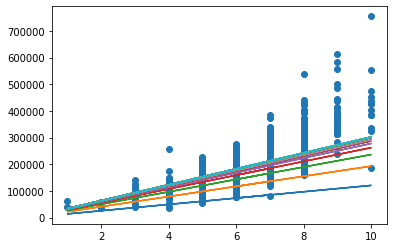

In [36]:
mod_regresion_lineal(x, y, 0.01, 50, 10)

![title](img/20200601-194227.png)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
String experimento: ./logs/20200601-194256_lr=0.05_epochs=1000
Ejecucion: 0 Gradiente del error respecto de m y b: [0. 0.] error:  19409727000.0
Ejecucion: 50 Gradiente del error respecto de m y b: [ -4112.8203 -12215.696 ] error:  27213564000.0
Ejecucion: 100 Gradiente del error respecto de m y b: [ -9588.492 -23350.777] error:  38454227000.0
Ejecucion: 150 Gradiente del error respecto de m y b: [-16636.5  -33582.54] error:  54623863000.0
Ejecucion: 200 Gradiente del error respecto de m y b: [-25514.227 -43079.52 ] error:  77865886000.0
Ejecucion: 250 Gradiente del error respecto de m y b: [-36536.547 -52004.953] error:  111260450000.0
Ejecucion: 300 Gradiente del error respecto de m y b: [-50085.812 -60519.816] error:  159230800000.0
Ejecucion: 350 Gradiente del error respecto de m y b: [-66625.28  -68786.484] error:  228130650000.0
Ejecucion: 400 Gradiente del erro

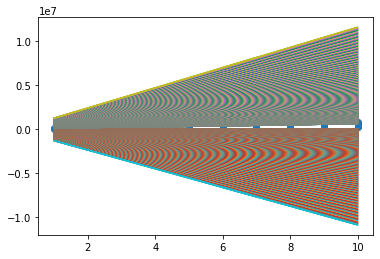

In [38]:
mod_regresion_lineal(x, y, 0.05, 1000, 50)

![title](img/20200601-194256.png)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
String experimento: ./logs/20200601-194317_lr=0.008_epochs=1000
Ejecucion: 0 Gradiente del error respecto de m y b: [0. 0.] error:  19409727000.0
Ejecucion: 50 Gradiente del error respecto de m y b: [29922.504  2729.053] error:  1385553500.0
Ejecucion: 100 Gradiente del error respecto de m y b: [30213.152    867.6656] error:  1376682100.0
Ejecucion: 150 Gradiente del error respecto de m y b: [30498.348    -958.79407] error:  1368140200.0
Ejecucion: 200 Gradiente del error respecto de m y b: [30778.191  -2750.9814] error:  1359916200.0
Ejecucion: 250 Gradiente del error respecto de m y b: [31052.783 -4509.539] error:  1351997200.0
Ejecucion: 300 Gradiente del error respecto de m y b: [31322.223 -6235.098] error:  1344373000.0
Ejecucion: 350 Gradiente del error respecto de m y b: [31586.605 -7928.279] error:  1337032100.0
Ejecucion: 400 Gradiente del error respecto de m

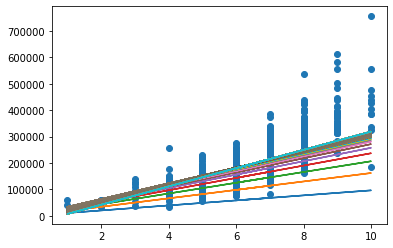

In [39]:
mod_regresion_lineal(x, y, 0.008, 1000, 50)

![title](img/20200601-194317.png)

## Conclusiones

Analizando con múltiples variables de learning rates y epochs, definitivamente los mejores parámetros para entrenar el modelo de forma eficiente serían los siguientes:

learning rate = 0.01
epochs = 1000

Con estos parámetros se disminuye eficientemente el error, y el número de iteraciones es relativamente bajo, por lo que el entrenamiento del modelo lleva muy poco tiempo.